In [1]:
# import libraries and modules required
from google.colab import drive
from google.colab.patches import cv2_imshow

import tensorflow as tf
import keras
from tensorflow.keras import *
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.utils import *
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Activation
import tensorflow.keras.backend as K

import glob, os, cv2
import numpy as np
from tqdm import tqdm

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Unzip uploaded dataset zip file and set the path for it
PATH = '/content/tmp'
ZIP_PATH = '/content/drive/MyDrive/dataset.zip'

os.makedirs(PATH, exist_ok=True)
!unzip $ZIP_PATH -d /content/tmp/ > /dev/null

file_list = glob.glob('/content/tmp/*.jpg') # edit the directory to your own path

In [3]:
# Save the desired output (goal) with the input data
label=[]
img=[]

for file in tqdm(file_list):
  X = cv2.imread(file)

  try:
    label.append([float(file.split('/')[-1].split('_')[0]), float(file.split('/')[-1].split('_')[1])])
    img.append(X[130:280, :])
  except:
    pass



input = label
label=np.array(input)
img=np.array(img)

label=(label-150)/150 # Goal range -1 to 1 (keep in mind for your activation functions)

label.shape, img.shape # verify the features of the dataset

100%|██████████| 847/847 [00:00<00:00, 1028.77it/s]


((847, 2), (847, 150, 300, 3))

In [4]:
# define custom activation function
def mish(x):
  return x * K.tanh(K.softplus(x))

# define early stop configuration
def scheduler(epoch, learningrate):
  if epoch < 100:
    return learningrate
  else:
    return learningrate * tf.math.exp(-0.1)

get_custom_objects().update({'mish': Activation(mish)})

In [17]:
# define the architecture of a model
input1 = Input(shape=(150, 300, 3,))
conv1 = Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), padding="same")(input1)
norm1 = BatchNormalization()(conv1)
act1 = Activation(mish)(norm1)
pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(act1)
conv2 = Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), padding="same")(pool1)
norm2 = BatchNormalization()(conv2)
act2 = Activation(mish)(norm2)
conv3 = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same")(act2)
norm3 = BatchNormalization()(conv3)
act3 = Activation(mish)(norm3)
add1 = Add()([act2, act3])
conv4 = Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), padding="same")(add1)
norm4 = BatchNormalization()(conv4)
act4 = Activation(mish)(norm4)
conv5 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(act4)
norm5 = BatchNormalization()(conv5)
act5 = Activation(mish)(norm5)
add2 = Add()([act4, act5])
conv6 = Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2), padding="same")(add2)
norm6 = BatchNormalization()(conv6)
act6 = Activation(mish)(norm6)
conv7 = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding="same")(act6)
norm7 = BatchNormalization()(conv7)
act7 = Activation(mish)(norm7)
add3 = Add()([act6, act7])
conv8 = Conv2D(filters=256, kernel_size=(3, 3), strides=(2, 2), padding="same")(add3)
norm8 = BatchNormalization()(conv8)
act8 = Activation(mish)(norm8)
conv9 = Conv2D(filters=512, kernel_size=(3, 3), strides=(2, 2), padding="same")(act8)
norm9 = BatchNormalization()(conv9)
act9 = Activation(mish)(norm9)
flat1 = Flatten()(act9)
dense1 = Dense(128)(flat1)
norm10 = BatchNormalization()(dense1)
act10 = Activation(mish)(norm10)
dense2 = Dense(64)(act10)
norm11 = BatchNormalization()(dense2)
act11 = Activation(mish)(norm11)
dense3 = Dense(64)(act11)
norm12 = BatchNormalization()(dense3)
act12 = Activation(mish)(norm12)
dense4 = Dense(2, activation="tanh")(act12) # 1개 출력형태로 수정

model = Model(inputs=input1, outputs=dense4)

In [19]:
# set condition for training
es = EarlyStopping(monitor='val_loss', mode='min', patience=15, min_delta=1e-4)
mc = ModelCheckpoint(filepath='/content/JMH6.h5', monitor='val_loss', mode='min', save_best_only=True)
lr = LearningRateScheduler(scheduler)

opt = Adam()
model.compile(optimizer=opt, loss='MAE')
model.optimizer.learning_rate.numpy()

np.float32(0.001)

In [20]:
# train
model.fit(x=img, y=label, epochs=1000, batch_size=32, validation_split=0.1, callbacks=[mc, es, lr])

Epoch 1/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.4406

24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 417ms/step - loss: 0.4375 - val_loss: 0.8902 - learning_rate: 0.0010
Epoch 2/1000
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2088

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2075 - val_loss: 0.5977 - learning_rate: 0.0010
Epoch 3/1000
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1564

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1554 - val_loss: 0.2339 - learning_rate: 0.0010
Epoch 4/1000
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1257

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1254 - val_loss: 0.1702 - learning_rate: 0.0010
Epoch 5/1000
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1067

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1069 - val_loss: 0.1364 - learning_rate: 0.0010
Epoch 6/1000
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1033

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1038 - val_loss: 0.1096 - learning_rate: 0.0010
Epoch 7/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1104 - val_loss: 0.1205 - learning_rate: 0.0010
Epoch 8/1000
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1093

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1087 - val_loss: 0.1034 - learning_rate: 0.0010
Epoch 9/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0938 - val_loss: 0.1131 - learning_rate: 0.0010
Epoch 10/1000
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0959

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0967 - val_loss: 0.0940 - learning_rate: 0.0010
Epoch 11/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1012 - val_loss: 0.1064 - learning_rate: 0.0010
Epoch 12/1000
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0898

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0894 - val_loss: 0.0902 - learning_rate: 0.0010
Epoch 13/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0835 - val_loss: 0.0974 - learning_rate: 0.0010
Epoch 14/1000
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0945

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0940 - val_loss: 0.0848 - learning_rate: 0.0010
Epoch 15/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0773 - val_loss: 0.1044 - learning_rate: 0.0010
Epoch 16/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0792 - val_loss: 0.0960 - learning_rate: 0.0010
Epoch 17/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0805 - val_loss: 0.0876 - learning_rate: 0.0010
Epoch 18/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0911 - val_loss: 0.0864 - learning_rate: 0.0010
Epoch 19/1000
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0712

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0715 - val_loss: 0.0838 - learning_rate: 0.0010
Epoch 20/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0634 - val_loss: 0.0946 - learning_rate: 0.0010
Epoch 21/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0725 - val_loss: 0.1019 - learning_rate: 0.0010
Epoch 22/1000
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0759

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0762 - val_loss: 0.0806 - learning_rate: 0.0010
Epoch 23/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0729 - val_loss: 0.0890 - learning_rate: 0.0010
Epoch 24/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0712 - val_loss: 0.0864 - learning_rate: 0.0010
Epoch 25/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0708 - val_loss: 0.0946 - learning_rate: 0.0010
Epoch 26/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0703 - val_loss: 0.0984 - learning_rate: 0.0010
Epoch 27/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0710 - val_loss: 0.0842 - learning_rate: 0.0010
Epoch 28/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0680 - val_loss: 0.0990 - learning_rate: 0.0010
Epoch 29/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0705 - val_loss: 0.0836 - learning_rate: 0.0010
Epoch 30/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0693 - val_loss: 0.0907 - learning_rate: 0.0010
Epoch 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


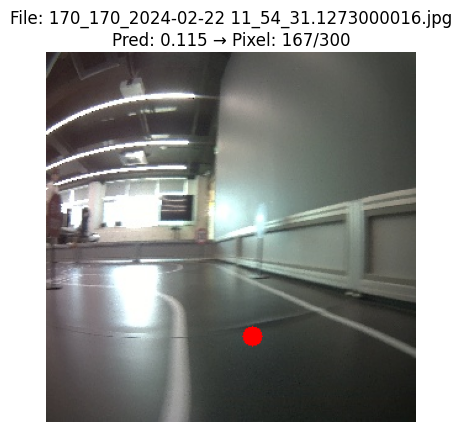

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


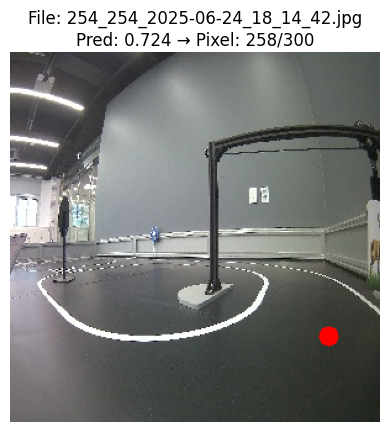

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


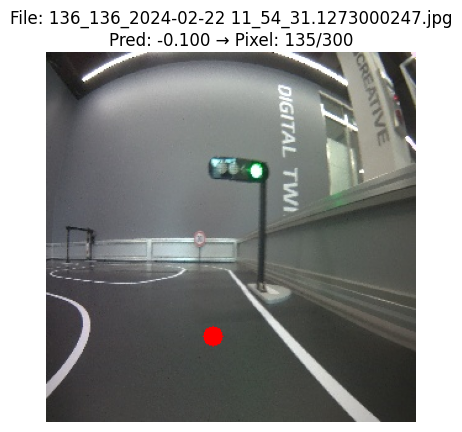

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


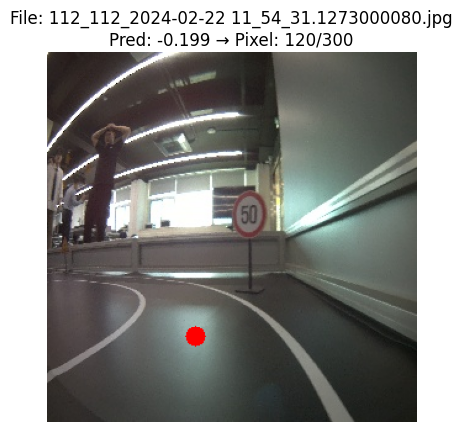

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


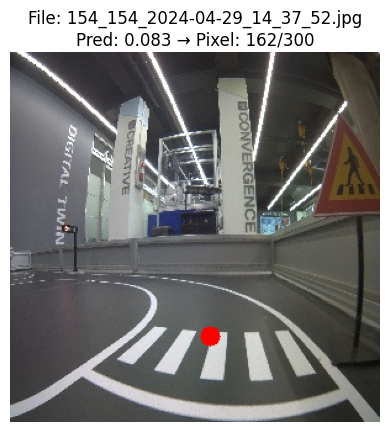

In [14]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# 추론 및 시각화 함수
def predict_and_visualize_batch(model_path, image_folder, input_size=(150, 300), crop_bottom=True, n=5):
    model = load_model(model_path, compile=False)
    img_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
    samples = random.sample(img_files, n)

    for sample_file in samples:
        sample_path = os.path.join(image_folder, sample_file)
        img = cv2.imread(sample_path)

        if crop_bottom:
            img_crop = img[130:280, :]
        else:
            img_crop = img

        img_input = np.expand_dims(img_crop, axis=0).astype(np.float32)
        pred = model.predict(img_input)[0][0]  # 정규화된 조향값 (-1 ~ 1)
        pixel_x = int((pred * 150) + 150)      # 정규화 해제 (0 ~ 300 픽셀)

        # 이미지에 예측값 표시
        vis_img = cv2.circle(img.copy(), (pixel_x, 230), 8, (0, 0, 255), -1)

        # 시각화
        plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
        plt.title(f"File: {sample_file}\nPred: {pred:.3f} → Pixel: {pixel_x}/300")
        plt.axis('off')
        plt.show()

# 예시 호출
predict_and_visualize_batch(
    model_path='/content/JMH6.h5',
    image_folder='/content/tmp',
    n=5
)
